In [1]:
%pip install ultralytics
%pip install super-gradients
%pip install supervision
%pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.9/715.9 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 50.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 83.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 6.6 MB/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 1.2 MB/s eta 0:00:00


In [2]:
from ultralytics import NAS

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from super_gradients.training import models
import torch
DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"

best_model = models.get(
    'yolo_nas_l',
    num_classes=1,
    checkpoint_path="/content/drive/MyDrive/5Modelos_Yolov8_DatasetTumor/Train6YoloNAS/average_model.pth"
).to(DEVICE)


The console stream is logged into /root/sg_logs/console.log


[2024-02-21 13:35:58] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2024-02-21 13:35:58] WARNING - __init__.py - Failed to import pytorch_quantization
[2024-02-21 13:36:05] WARNING - calibrator.py - Failed to import pytorch_quantization
[2024-02-21 13:36:05] WARNING - export.py - Failed to import pytorch_quantization
[2024-02-21 13:36:05] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2024-02-21 13:36:05] WARNING - env_sanity_check.py - Failed to verify installed packages: boto3 required but not found
[2024-02-21 13:36:05] WARNING - env_sanity_check.py - Failed to verify installed packages: deprecated required but not found
[2024-02-21 13:36:05] WARNING - env_sanity_check.py - Failed to verify installed packages: coverage required but not found
[2024-02-21 13:36:05] WARNING - env_sanity_check.py - Failed to verify installed packages: sphinx-rtd-theme required but not fo

In [ ]:
import supervision as sv
import ultralytics

def get_inference(path_project):
  ds = sv.DetectionDataset.from_yolo(
      images_directory_path=f"{path_project}/images",
      annotations_directory_path=f"{path_project}/labels",
      data_yaml_path=f"/content/drive/MyDrive/CsiLab-BrainTumor-Detection-3/data.yaml",
      force_masks=False
  )

  CONFIDENCE_TRESHOLD = 0.5
  predictions = {}
  for image_name, image in ds.images.items():
    result =best_model.predict(image, conf=CONFIDENCE_TRESHOLD)
    detections = sv.Detections(
        xyxy=result.prediction.bboxes_xyxy,
        confidence=result.prediction.confidence,
        class_id=result.prediction.labels.astype(int),
    )
    predictions[image_name] = detections

    nome_imagem = image_name.split('/')[7] + ".txt"
    with open(f"/content/drive/MyDrive/5Modelos_Yolov8_DatasetTumor/Train6YoloNAS/inferencias/{nome_imagem}","w") as file:
      if(len(detections.xyxy) > 0):
        file.write(str(detections.xyxy[-1]))
      else:
        file.write('[]')

get_inference("/content/drive/MyDrive/CsiLab-BrainTumor-Detection-3/test")
get_inference("/content/drive/MyDrive/CsiLab-BrainTumor-Detection-3/train")
get_inference("/content/drive/MyDrive/CsiLab-BrainTumor-Detection-3/valid")

In [27]:
import supervision as sv
import ultralytics
box_annotator = sv.BoxAnnotator()

images = []
titles = []

detections_list = []
prediction_list = []

with open("/content/drive/MyDrive/5Modelos_Yolov8_DatasetTumor/Train6YoloNAS/detections.txt",'w') as file:
  file.write('')
with open("/content/drive/MyDrive/5Modelos_Yolov8_DatasetTumor/Train6YoloNAS/predictions.txt",'w') as file:
  file.write('')

def get_ioudata(path_project):
  ds = sv.DetectionDataset.from_yolo(
      images_directory_path=f"{path_project}/images",
      annotations_directory_path=f"{path_project}/labels",
      data_yaml_path=f"/content/drive/MyDrive/CsiLab-BrainTumor-Detection-3-allinone/data.yaml",
      force_masks=False
  )
  CONFIDENCE_TRESHOLD = 0.5
  predictions = {}
  for image_name, image in ds.images.items():
    result = best_model.predict(image, conf=CONFIDENCE_TRESHOLD)
    detections = sv.Detections(
        xyxy=result.prediction.bboxes_xyxy,
        confidence=result.prediction.confidence,
        class_id=result.prediction.labels.astype(int)
    )
    predictions[image_name] = detections

  keys = list(ds.images.keys())
  for key in keys:
      # Para anotações
      annotation_detections = ds.annotations[key]
      for detection in annotation_detections:
          detections_list.append(detection[0])
          with open("/content/drive/MyDrive/5Modelos_Yolov8_DatasetTumor/Train6YoloNAS/detections.txt",'a') as file:
            file.write(str(detection)+'\n')

      # Para previsões
      if len(predictions[key].xyxy) > 0:
        predictions[key].xyxy = predictions[key].xyxy[-1]
      prediction_detections = predictions[key]
      prediction_list.append(prediction_detections)
      with open("/content/drive/MyDrive/5Modelos_Yolov8_DatasetTumor/Train6YoloNAS/predictions.txt",'a') as file:
        file.write(str(prediction_detections)+ '\n')

get_ioudata("/content/drive/MyDrive/CsiLab-BrainTumor-Detection-3-allinone/data")


/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
[2024-02-21 14:41:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-21 14:41:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-21 14:41:28] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-21 14:41:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-21 14:41:36] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-21 14

In [12]:
import numpy as np

with open("/content/drive/MyDrive/5Modelos_Yolov8_DatasetTumor/Train6YoloNAS/Iou.txt",'w') as file:
      file.write('')

iou_values = []
def calculate_iou(box1, box2):
    # Calcular a interseção
    x_intersection = max(0, min(box1[2], box2[2]) - max(box1[0], box2[0]))
    y_intersection = max(0, min(box1[3], box2[3]) - max(box1[1], box2[1]))
    area_intersection = x_intersection * y_intersection

    # Calcular a união
    area_box1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area_box2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    area_union = area_box1 + area_box2 - area_intersection

    # Calcular a IoU
    iou = area_intersection / max(area_union, 1e-10)  # Evitar divisão por zero

    return iou

for i in range(len(detections_list)):
  try:
    iou_score = calculate_iou(detections_list[i], prediction_list[i].xyxy)
  except Exception as e:
    print("Iou não calculado", i, e)
    iou_score = 0.0
  finally:
    iou_values.append(iou_score)
    with open("/content/drive/MyDrive/5Modelos_Yolov8_DatasetTumor/Train6YoloNAS/Iou.txt",'a') as file:
      file.write(str(iou_score)+ '\n')

print(np.mean(iou_values))

Iou não calculado 3 index 2 is out of bounds for axis 0 with size 0
Iou não calculado 67 index 2 is out of bounds for axis 0 with size 0
Iou não calculado 181 index 2 is out of bounds for axis 0 with size 0
0.8903373095112811


In [130]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Função para calcular o IoU entre dois bounding boxes
def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    xmin1, ymin1, xmax1, ymax1 = x1 - w1/2, y1 - h1/2, x1 + w1/2, y1 + h1/2
    xmin2, ymin2, xmax2, ymax2 = x2 - w2/2, y2 - h2/2, x2 + w2/2, y2 + h2/2

    intersect_xmin = max(xmin1, xmin2)
    intersect_ymin = max(ymin1, ymin2)
    intersect_xmax = min(xmax1, xmax2)
    intersect_ymax = min(ymax1, ymax2)

    intersect_width = max(0, intersect_xmax - intersect_xmin)
    intersect_height = max(0, intersect_ymax - intersect_ymin)

    intersect_area = intersect_width * intersect_height

    box1_area = w1 * h1
    box2_area = w2 * h2

    union_area = box1_area + box2_area - intersect_area

    iou = intersect_area / union_area if union_area > 0 else 0

    return iou

# Função para calcular a média do IoU para um DataFrame
def calculate_mean_iou(df):
    iou_values = []
    for _, row in df.iterrows():
        box1 = (row['x1'], row['y1'], row['w1'], row['h1'])
        box2 = (row['x2'], row['y2'], row['w2'], row['h2'])
        iou_values.append(calculate_iou(box1, box2))
    return np.mean(iou_values)

# Função para contar quantos labels de cada modelo têm IoU maior que determinado limiar
def count_labels_iou(df, iou_threshold):
    count = sum(calculate_iou((row['x1'], row['y1'], row['w1'], row['h1']),
                              (row['x2'], row['y2'], row['w2'], row['h2'])) > iou_threshold
                for _, row in df.iterrows())
    return count

# Função para gerar a matriz de confusão para um DataFrame
def generate_confusion_matrix(df):
    y_true = df['y_true'].values
    y_pred = df['y_pred'].values
    return confusion_matrix(y_true, y_pred)
'''
# Pasta contendo os arquivos Excel
excel_folder = "output_excel"

# Lista de arquivos na pasta de Excel
excel_files = os.listdir(excel_folder)

# Avaliar cada arquivo Excel
for excel_file in excel_files:
    # Carregar o DataFrame do arquivo Excel
    df = pd.read_excel(os.path.join(excel_folder, excel_file))

    # Calcular a média do IoU
    mean_iou = calculate_mean_iou(df)

    # Contar quantos labels têm IoU maior que 0.5, 0.7 e 0.9
    count_iou_05 = count_labels_iou(df, 0.5)
    count_iou_07 = count_labels_iou(df, 0.7)
    count_iou_09 = count_labels_iou(df, 0.9)

    # Gerar a matriz de confusão
    confusion_mat = generate_confusion_matrix(df)

    # Salvar a matriz de confusão em um arquivo Excel
    confusion_mat_df = pd.DataFrame(confusion_mat)
    output_filename = excel_file.replace('.xlsx', '_confusion_matrix.xlsx')
    confusion_mat_df.to_excel(os.path.join(excel_folder, output_filename), index=False)

    # Mostrar os resultados
    print(f"Resultados para o arquivo Excel: {excel_file}")
    print(f"Média do IoU: {mean_iou}")
    print(f"Número de labels com IoU > 0.5: {count_iou_05}")
    print(f"Número de labels com IoU > 0.7: {count_iou_07}")
    print(f"Número de labels com IoU > 0.9: {count_iou_09}")
    print(f"Matriz de Confusão:\n{confusion_mat}")
    print("\n")'''


'\n# Pasta contendo os arquivos Excel\nexcel_folder = "output_excel"\n\n# Lista de arquivos na pasta de Excel\nexcel_files = os.listdir(excel_folder)\n\n# Avaliar cada arquivo Excel\nfor excel_file in excel_files:\n    # Carregar o DataFrame do arquivo Excel\n    df = pd.read_excel(os.path.join(excel_folder, excel_file))\n    \n    # Calcular a média do IoU\n    mean_iou = calculate_mean_iou(df)\n    \n    # Contar quantos labels têm IoU maior que 0.5, 0.7 e 0.9\n    count_iou_05 = count_labels_iou(df, 0.5)\n    count_iou_07 = count_labels_iou(df, 0.7)\n    count_iou_09 = count_labels_iou(df, 0.9)\n    \n    # Gerar a matriz de confusão\n    confusion_mat = generate_confusion_matrix(df)\n    \n    # Salvar a matriz de confusão em um arquivo Excel\n    confusion_mat_df = pd.DataFrame(confusion_mat)\n    output_filename = excel_file.replace(\'.xlsx\', \'_confusion_matrix.xlsx\')\n    confusion_mat_df.to_excel(os.path.join(excel_folder, output_filename), index=False)\n    \n    # Mostrar 

<ipython-input-131-a4c7b62e2739>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred_list.append(int(prediction_list[i].class_id))


[[275  12]
 [  0   0]]


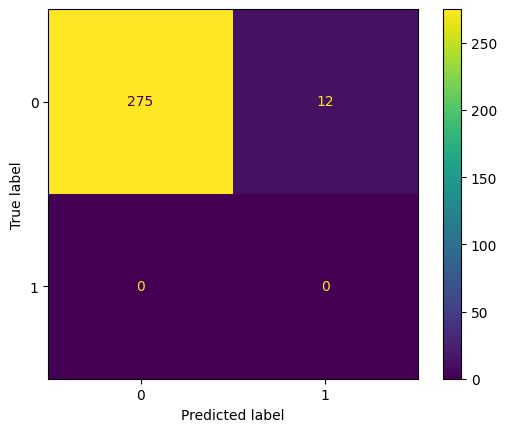

In [131]:
data_true = np.loadtxt('/content/drive/MyDrive/5Modelos_Yolov8_DatasetTumor/Train6YoloNAS/detections.txt', dtype= str, delimiter = ',')
y_true_list = []
y_pred_list = []
for i in range(len(data_true)):
  y_true_list.append(int(data_true[i][7]))
  try:
    y_pred_list.append(int(prediction_list[i].class_id))
  except Exception as e:
    y_pred_list.append(1)

df = pd.DataFrame({"y_true":y_true_list,"y_pred":y_pred_list})
print(generate_confusion_matrix(df))
disp = ConfusionMatrixDisplay(generate_confusion_matrix(df))
disp.plot()
